### **Imports**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from robolab_turtlebot import Turtlebot
from TurtleControllers import TurtlebotController
from TurtleVision import TurtlebotVision
from TurtleMap import TurtlebotMap
from TurtleICP import TurtlebotICP
import TurtleUtils
import time
import loggingSetup
import logging
logger = logging.getLogger("robot")

  ### **Initialization**

In [2]:
turtle = Turtlebot(rgb=True, pc=True)
turtle_controller = TurtlebotController(turtle, rate=40)
turtle_vision = TurtlebotVision(turtle)
turtle_map_yellow = TurtlebotMap()  # Map for yellow points in images
turtle_map_purple = TurtlebotMap()  # Map for purple points in images
turtle_icp = TurtlebotICP()

### **Scanning**

In [3]:
def scan(r2p=False):
    current_yaw = turtle_controller.get_odometry()[1]
    angles = np.linspace(current_yaw, current_yaw + 2 * np.pi, 12)
    for angle in angles:
        # Scan environment
        yellow_points = turtle_vision.sample_garage(color="yellow", r2p=r2p)
        purple_points = turtle_vision.sample_garage(sampling_step=3,
                                                    color="purple", minimal_size=8, r2p=r2p)

        # Current odometry
        odom = turtle_controller.get_odometry()

        # Add points to maps
        turtle_map_yellow.add_points(yellow_points, odom)
        turtle_map_purple.add_points(purple_points, odom)

        # Rotate to next position
        turtle_controller.rotate(angle, relative=False, tol=0.1)
        time.sleep(1.0)

### **Fit garage model**

In [4]:
def task2():
    # Scan environment
    scan()

    # Task1 if there are some purple clusters
    use_task1 = turtle_map_purple.cluster_count >= 2

    if use_task1:
        print("Use task1")
        return

    turtle_map_purple.reset()

    # Fit garage model using ICP
    yellow_downsampled = turtle_map_yellow.points_downsampled
    TurtleUtils.robot2plt_numpy(yellow_downsampled)
    opt = turtle_icp.optimize(yellow_downsampled)
    garage = opt.garage

    # For now assume the garage fit is perfect
    pt, idx, should_scan = garage.closest_waypoint(turtle_controller.get_odometry())

    while idx != 0:
        # Move to closest waypoint
        turtle_controller.move_to(pt, relative=False)

        if should_scan:
            task2()
            return

        pt, idx, should_scan = garage.closest_waypoint(idx)

    # Should be near the entrance
    task2()

Executing Task2
Executing Scan


/home.nfs/bastaond/LAR/TurtleVision.py:54: RuntimeWarning: Mean of empty slice
  column_mean = np.nanmean(depth_image_strip, axis=0)


Optimizing ... Angle 0
Angle 60
Angle -60
Angle 120
Angle -120
Done
Optimization time: 2.85 s


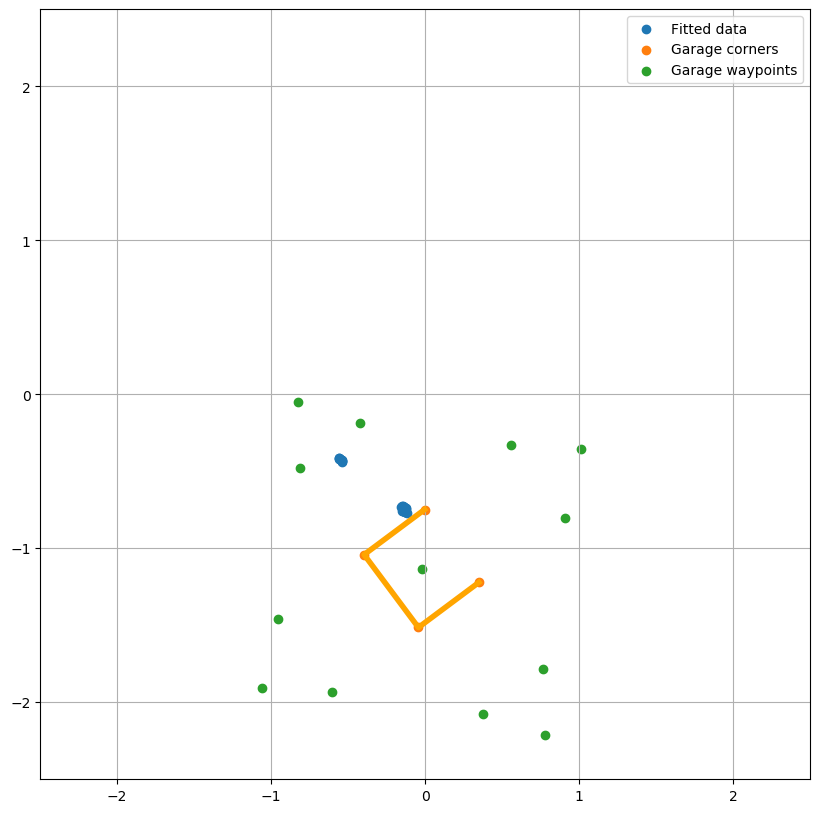

Old index: 4, New index: 2
Old index: 2, New index: 1
Old index: 1, New index: 0
Executing Task2
Executing Scan


/home.nfs/bastaond/LAR/TurtleVision.py:54: RuntimeWarning: Mean of empty slice
  column_mean = np.nanmean(depth_image_strip, axis=0)


Optimizing ... Angle 0
Angle 60
Angle -60
Angle 120
Angle -120
Done
Optimization time: 7.04 s


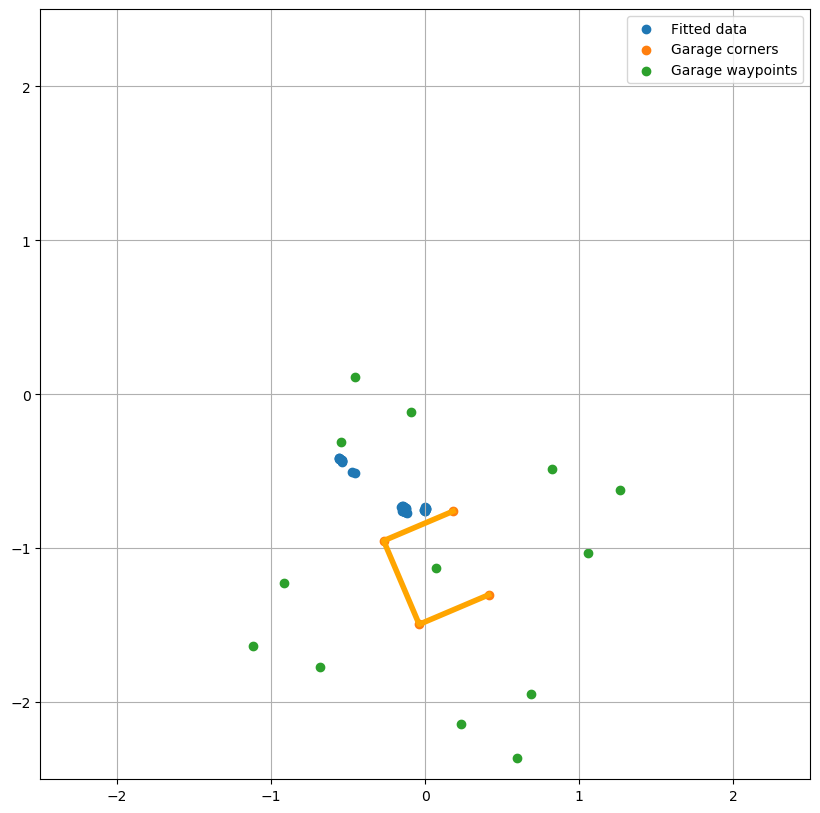

Old index: 2, New index: 1
Old index: 1, New index: 0
Executing Task2
Executing Scan


/home.nfs/bastaond/LAR/TurtleVision.py:54: RuntimeWarning: Mean of empty slice
  column_mean = np.nanmean(depth_image_strip, axis=0)


Optimizing ... Angle 0
Angle 60
Angle -60
Angle 120
Angle -120
Done
Optimization time: 16.03 s


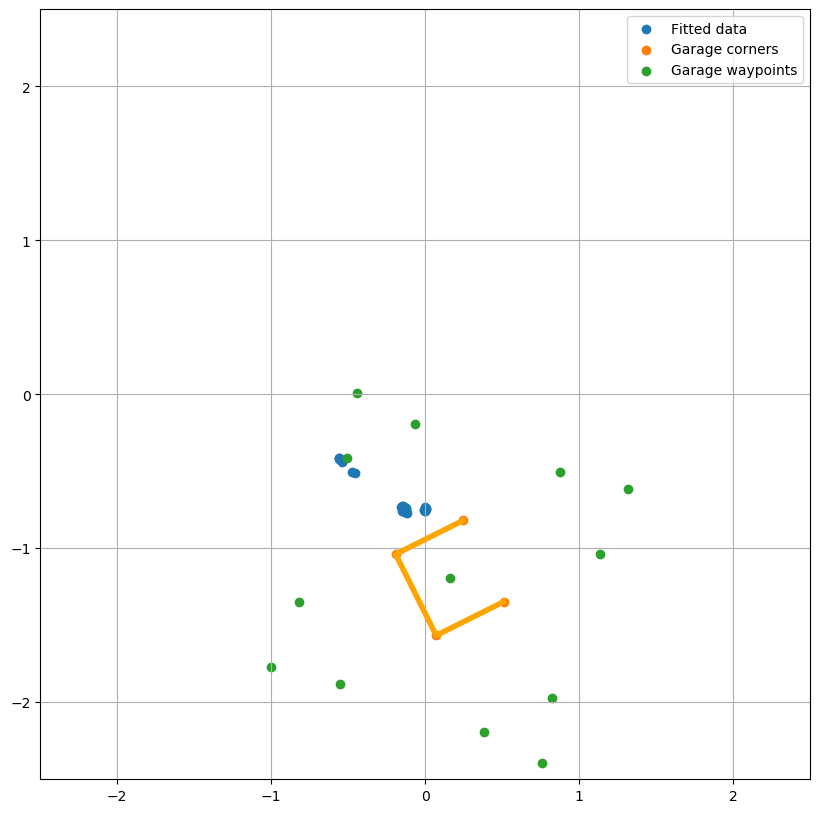

Old index: 1, New index: 0
Executing Task2
Executing Scan


/home.nfs/bastaond/LAR/TurtleVision.py:54: RuntimeWarning: Mean of empty slice
  column_mean = np.nanmean(depth_image_strip, axis=0)


Optimizing ... Angle 0
Angle 60
Angle -60
Angle 120
Angle -120
Done
Optimization time: 23.64 s


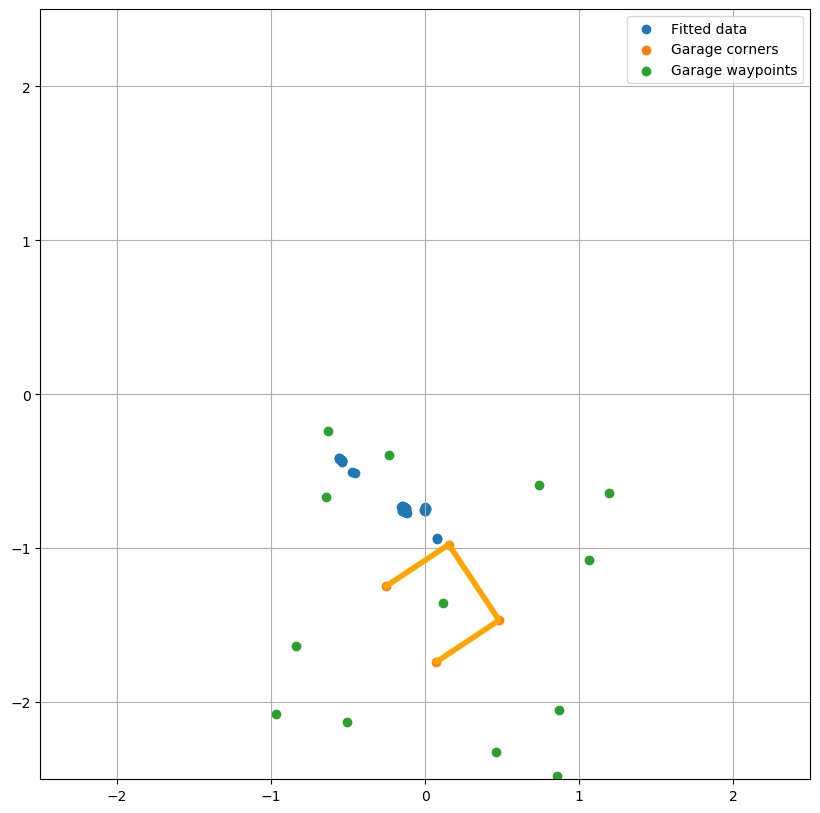

Old index: 12, New index: 10


In [ ]:
import abc
from typing import Dict


class State(abc.ABC):
    name = "default"

    def __init__(self, automat: "Automat"):
        self.automat = automat

    def execute(self) -> "State":
        print(f"Executing {self.name}")
        self.action()
        return self.get_next_state()

    @abc.abstractmethod
    def action(self):
        pass

    @abc.abstractmethod
    def get_next_state(self):
        pass


class End(State):
    name = "End"

    def get_next_state(self):
        return None

    def action(self):
        print("Done")


class Task1(State):
    name = "Task1"

    def action(self):
        print("Doing task 1")

    def get_next_state(self):
        return self.automat.states["End"]


class Scan(State):
    name = "Scan"

    def action(self):
        r2p = False
        current_yaw = self.automat.turtle_controller.get_odometry()[1]
        angles = np.linspace(current_yaw, current_yaw + 2 * np.pi, 12)
        for angle in angles:
            # Scan environment
            yellow_points = self.automat.turtle_vision.sample_garage(color="yellow", r2p=r2p)
            purple_points = self.automat.turtle_vision.sample_garage(sampling_step=3,
                                                                     color="purple", minimal_size=8, r2p=r2p)

            # Current odometry
            odom = turtle_controller.get_odometry()

            # Add points to maps
            self.automat.turtle_map_yellow.add_points(yellow_points, odom)
            self.automat.turtle_map_purple.add_points(purple_points, odom)

            # Rotate to next position
            self.automat.turtle_controller.rotate(angle, relative=False, tol=0.1)
            time.sleep(1.0)

    def get_next_state(self):
        # TODO: Refactor this mess
        use_task1 = turtle_map_purple.cluster_count >= 2

        if use_task1:
            return self.automat.states["Task1"]

            self.automat.turtle_map_purple.reset()

        # Fit garage model using ICP
        yellow_downsampled = self.automat.turtle_map_yellow.points_downsampled
        yellow_downsampled = TurtleUtils.robot2plt_numpy(yellow_downsampled)
        opt = turtle_icp.optimize(yellow_downsampled)
        garage = opt.garage
        TurtleUtils.plot_fitted_garage(
            garage,
            TurtleUtils.robot2plt_numpy(self.automat.turtle_map_purple.points_filtered)
        )

        pt, idx, should_scan = garage.closest_waypoint(turtle_controller.get_odometry())

        while idx != 0:
            # Move to closest waypoint
            self.automat.turtle_controller.move_to(pt, relative=False)

            if should_scan:
                return self.automat.states["Task2"]

            idx_prev = idx
            pt, idx, should_scan = garage.closest_waypoint(idx)
            print(f"Old index: {idx_prev}, New index: {idx}")

        return self.automat.states["Task2"]


class Task2(State):
    name = "Task2"

    def action(self):
        pass

    def get_next_state(self):
        return self.automat.states["Scan"]


class Automat:
    def __init__(self, states: list = None):
        self.states: Dict[str, State] = {}
        for state_cls in states:
            state = state_cls(self)
            self.states[state.name] = state
            assert state.name != "default", f"Name for state {state_cls} is not set"

        self.state: State = list(self.states.values())[0]

    def execute(self):
        while self.state:
            self.state = self.state.execute()


class Pycomat(Automat):
    def __init__(self):
        super().__init__([Task2, Scan, Task1, End])
        self.turtle = Turtlebot(rgb=True, pc=True)
        self.turtle_controller = TurtlebotController(self.turtle, rate=40)
        self.turtle_vision = TurtlebotVision(self.turtle)
        self.turtle_map_yellow = TurtlebotMap()  # Map for yellow points in images
        self.turtle_map_purple = TurtlebotMap()  # Map for purple points in images
        self.turtle_icp = TurtlebotICP()

logger.info("Starting run")
automat = Pycomat()
automat.execute()